In [22]:
#1. Perform sentiment analysis using BERT and SOLAR with the prompt: 
#”What sentiments are primarily expressed in the following movie review: ”.
#2. Conduct feature analysis to identify and visualize relationships 
#and outliers using frequency histograms, scatter plots, and word clouds.
#3. Project reviews into 2D using PCA and t-SNE to visualize potential clustering

In [1]:
import pandas as pd
import numpy as np
np.random.seed(701)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import duckdb

In [2]:
try:
    db.close()
    del db
except:
    pass
db = duckdb.connect(database='embeddings.db', read_only=False)
db.execute("SELECT * FROM embeddings384 LIMIT 1").fetch_df().columns

Index(['Viewer', 'Movie', 'Sentiment', 'Reviews', 'EmbeddingValue', 'ID',
       'EmbeddingValue100'],
      dtype='object')

## 2. Feature Analysis

### 2.1. Importing Libraries 

In [2]:
from keybert import KeyBERT
from tqdm import tqdm

[2024-05-13 02:48:59,886] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### 2.2. Loading Data

In [30]:
# Load the data
df = db.execute("SELECT * FROM embeddings384").fetch_df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Viewer,Movie,Sentiment,Reviews,EmbeddingValue,ID,EmbeddingValue100
0,Audience,war_of_the_worlds,Negative,overall good movie but it wasnt near as good a...,"[-0.09393362, 0.14137916, -0.012300838, -0.044...",102401,"[-0.11742478, 0.03308921, 0.09725712, 0.013549..."
1,Audience,war_of_the_worlds,Negative,another classic spielberg movie,"[-0.08732375, 0.12564541, -0.017482644, -0.045...",102402,"[-0.100036055, 0.013633809, 0.030069213, -0.12..."
2,Audience,war_of_the_worlds,Negative,not as good as the original and im not a fan o...,"[-0.09374756, 0.1473561, 0.008707689, -0.04181...",102403,"[-0.12708674, 0.05111915, 0.054715153, -0.0476..."
3,Audience,war_of_the_worlds,Negative,that scene close to the beginning where all of...,"[-0.07822682, 0.13861911, 0.009358808, -0.0535...",102404,"[-0.09054798, -0.06049514, -0.039423626, -0.03..."
4,Audience,war_of_the_worlds,Negative,i liked this a lot i think it is a genuinely k...,"[-0.07931607, 0.11045076, 0.011352594, -0.0490...",102406,"[-0.06397137, -0.11278004, -0.056537364, 0.073..."
...,...,...,...,...,...,...,...
253898,Audience,war_of_the_worlds,Negative,the war of the world is a good movie but the a...,"[-0.09388082, 0.12330725, 0.0031593172, -0.048...",101576,"[-0.08553253, -0.045614727, -0.031464137, -0.0..."
253899,Audience,war_of_the_worlds,Negative,i liked it but dont tell anyone,"[-0.106644556, 0.1439313, 0.0016598947, -0.040...",101901,"[-0.14402387, 0.07489632, 0.111372635, -0.0392..."
253900,Audience,war_of_the_worlds,Negative,what the heck did you do to this movie tom,"[-0.0961653, 0.14749579, -0.0041379724, -0.044...",101978,"[-0.1284718, 0.027810914, 0.034550477, -0.0750..."
253901,Audience,the_northman,Negative,poorly written ventured from plot into the rid...,"[-0.06841529, 0.10787069, 0.008072913, -0.0475...",100866,"[-0.10048548, 0.0073967334, 0.06254407, 0.1054..."


In [38]:
# Print each unique movie title
df['Movie'].unique()

array(['war_of_the_worlds', 'godzilla_minus_one', 'fifty_shades_of_grey',
       'mad_max_fury_road', 'aquaman_and_the_lost_kingdom', 'godzilla',
       'argylle', 'black_adam', 'marvels_the_avengers',
       'godzilla_king_of_the_monsters_2019', 'imaginary', 'madame_web',
       'megamind_vs_the_doom_syndicate', 'mortal_engines',
       'napoleon_2023', 'mission_impossible_fallout',
       'godzilla_x_kong_the_new_empire', 'oppenheimer_2023', 'omen',
       'meet_joe_black', 'puss_in_boots_the_last_wish',
       'star_wars_the_rise_of_skywalker', 'one_day_2014',
       'rebel_moon_part_1_a_child_of_fire', 'blair_witch_project',
       'the_lord_of_the_rings_the_two_towers',
       'the_super_mario_bros_movie', 'captain_marvel', 'venom_2018',
       'charlie_and_the_chocolate_factory', 'wish_2023',
       'captain_america_civil_war', 'cuties', 'ghostbusters_2016',
       'dune_2021', 'king_kong', 'dune_part_two', 'mulan_2020',
       'star_wars_the_last_jedi', 'the_northman'], dtype=ob

In [35]:
# Get statistics of the data
# Stats: 1. Number of reviews, 2. Number of words, 3. Average word length, 4. Number of unique words
# 5. Average number of words per review, 6. Number of positive and negative reviews, 7. Number of audience reviews
# 8. Number of critic reviews, 9. Number of positive and negative audience reviews, 10. Number of positive and negative critic reviews
# 11. Number of movies, 12. Number of positive and negative reviews per movie, 13. Number of positive and negative audience reviews per movie
# 14. Number of positive and negative critic reviews per movie

# 1. Number of reviews
num_reviews = df.shape[0]

# 2. Number of words
num_words = df['Reviews'].apply(lambda x: len(x.split())).sum()

# 3. Average word length
avg_word_len = df['Reviews'].apply(lambda x: np.mean([len(w) for w in x.split()]))
avg_word_len = avg_word_len.mean()

# 4. Number of unique words
num_unique_words = len(set(' '.join(df['Reviews']).split()))

# 5. Average number of words per review
avg_words_per_review = num_words / num_reviews

# 6. Number of positive and negative reviews
num_pos_reviews = df['Sentiment'].value_counts()['Positive']
num_neg_reviews = df['Sentiment'].value_counts()['Negative']

# 7. Number of audience reviews
num_audience_reviews = df['Viewer'].value_counts()['Audience']

# 8. Number of critic reviews
num_critic_reviews = df['Viewer'].value_counts()['Critic']

# 9. Number of positive and negative audience reviews
num_pos_audience_reviews = df[df['Viewer'] == 'Audience']['Sentiment'].value_counts()['Positive']
num_neg_audience_reviews = df[df['Viewer'] == 'Audience']['Sentiment'].value_counts()['Negative']

# 10. Number of positive and negative critic reviews
num_pos_critic_reviews = df[df['Viewer'] == 'Critic']['Sentiment'].value_counts()['Positive']
num_neg_critic_reviews = df[df['Viewer'] == 'Critic']['Sentiment'].value_counts()['Negative']

# 11. Number of movies
num_movies = df['Movie'].nunique()

# 12. Number of positive and negative reviews per movie
num_pos_reviews_per_movie = df.groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Positive']
num_neg_reviews_per_movie = df.groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Negative']

# 13. Number of positive and negative audience reviews per movie
num_pos_audience_reviews_per_movie = df[df['Viewer'] == 'Audience'].groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Positive']
num_neg_audience_reviews_per_movie = df[df['Viewer'] == 'Audience'].groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Negative']

# 14. Number of positive and negative critic reviews per movie
num_pos_critic_reviews_per_movie = df[df['Viewer'] == 'Critic'].groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Positive']
num_neg_critic_reviews_per_movie = df[df['Viewer'] == 'Critic'].groupby('Movie')['Sentiment'].value_counts().unstack().fillna(0)['Negative']

print(f"Number of reviews: {num_reviews}")
print(f"Number of words: {num_words}")
print(f"Average word length: {avg_word_len}")
print(f"Number of unique words: {num_unique_words}")
print(f"Average number of words per review: {avg_words_per_review}")
print(f"Number of positive reviews: {num_pos_reviews}")
print(f"Number of negative reviews: {num_neg_reviews}")
print(f"Number of audience reviews: {num_audience_reviews}")
print(f"Number of critic reviews: {num_critic_reviews}")
print(f"Number of positive audience reviews: {num_pos_audience_reviews}")
print(f"Number of negative audience reviews: {num_neg_audience_reviews}")
print(f"Number of positive critic reviews: {num_pos_critic_reviews}")
print(f"Number of negative critic reviews: {num_neg_critic_reviews}")
print(f"Number of movies: {num_movies}")
print(f"Number of positive reviews per movie: {num_pos_reviews_per_movie}")
print(f"Number of negative reviews per movie: {num_neg_reviews_per_movie}")
print(f"Number of positive audience reviews per movie: {num_pos_audience_reviews_per_movie}")
print(f"Number of negative audience reviews per movie: {num_neg_audience_reviews_per_movie}")
print(f"Number of positive critic reviews per movie: {num_pos_critic_reviews_per_movie}")
print(f"Number of negative critic reviews per movie: {num_neg_critic_reviews_per_movie}")

Number of reviews: 253903
Number of words: 11926092
Average word length: 4.44375889892554
Number of unique words: 129395
Average number of words per review: 46.97105587566905
Number of positive reviews: 143668
Number of negative reviews: 110235
Number of audience reviews: 250284
Number of critic reviews: 3619
Number of positive audience reviews: 141794
Number of negative audience reviews: 108490
Number of positive critic reviews: 1874
Number of negative critic reviews: 1745
Number of movies: 40
Number of positive reviews per movie: Movie
aquaman_and_the_lost_kingdom            2456.0
argylle                                 2650.0
black_adam                              8820.0
blair_witch_project                       96.0
captain_america_civil_war               9356.0
captain_marvel                            95.0
charlie_and_the_chocolate_factory         93.0
cuties                                    75.0
dune_2021                               9498.0
dune_part_two                    

In [36]:
# Unique words specific to audience and critic reviews
unique_words_audience = set(' '.join(df[df['Viewer'] == 'Audience']['Reviews']).split()) - set(' '.join(df[df['Viewer'] == 'Critic']['Reviews']).split())
unique_words_critic = set(' '.join(df[df['Viewer'] == 'Critic']['Reviews']).split()) - set(' '.join(df[df['Viewer'] == 'Audience']['Reviews']).split())

print(f"Unique words specific to audience reviews: {len(unique_words_audience)}")
print(f"Unique words specific to critic reviews: {len(unique_words_critic)}")

Unique words specific to audience reviews: 66484
Unique words specific to critic reviews: 26514


### 2.3. Data Description

In [11]:
# Perform keyphrase extraction
kw_model = KeyBERT('all-MiniLM-L6-v2')
# Create new table in the database
# If the table already exists, drop it
try:
        db.execute("DROP TABLE keyphrases")
except:
        pass
db.execute("CREATE TABLE IF NOT EXISTS keyphrases (id INTEGER, keyphrase VARCHAR, confidence FLOAT)")
# Insert the keyphrases into the database
data = db.execute("SELECT ID, Reviews FROM embeddings384").fetch_df()
outdata = pd.DataFrame(columns=['ID', 'Keyphrase', 'Confidence'])
for i in tqdm(range(len(data))):
        keywords = kw_model.extract_keywords(
                data['Reviews'][i],
                keyphrase_ngram_range=(1, 2),
                stop_words=None)
        for keyword, confidence in keywords:
                outdata = outdata.append({'ID': data['ID'][i], 'Keyphrase': keyword, 'Confidence': confidence}, ignore_index=True)
        # Prevent OOM
        if outdata.shape[0] > 10000:
                insert_query = (
                        'INSERT INTO keyphrases VALUES '
                        + ', '.join([f"({int(row['ID'])}, '{str(row['Keyphrase'])}', {float(row['Confidence'])})" for _, row in outdata.iterrows()])
                )
                db.execute(insert_query)
                outdata = pd.DataFrame(columns=['ID', 'Keyphrase', 'Confidence'])
insert_query = (
        'INSERT INTO keyphrases VALUES '
        + ', '.join([f"({int(row['ID'])}, '{str(row['Keyphrase'])}', {float(row['Confidence'])})" for _, row in outdata.iterrows()])
)
if len(outdata) > 0:
        db.execute(insert_query)
db.commit()

  0%|          | 1002/253903 [00:33<4:16:13, 16.45it/s]

In [80]:
# Filtering the keyphrases. Remove "movie review", "movie", and "movies",
# as well as any movie titles
db.execute("CREATE TABLE IF NOT EXISTS filtered_keyphrases (id INTEGER, keyphrase VARCHAR, confidence FLOAT)")
df = db.execute("SELECT * FROM keyphrases").fetch_df()
df['id'] = df['id'].astype(int)
filtered = df[~df['keyphrase'].str.contains('movie review|movie|movies|film|films', case=False)]
filtered


,id,keyphrase,confidence
1,102401,wasnt near,0.3747
3,102401,hoped,0.3552
4,102401,as expected,0.3492
5,102402,classic spielberg,0.8679
7,102402,spielberg,0.7280
...,...,...,...
1267575,100866,acting,0.4438
1267576,100866,acting and,0.4204
1267578,100869,an epic,0.4658
1267580,100869,epic but,0.4370


In [72]:
# Get 25 most confident keyphrases
top25 = filtered.groupby('keyphrase').mean().sort_values('confidence', ascending=False).head(25)
top25['id'] = top25['id'].astype(int)
top25 = top25.reset_index()
# Get the Sentiment, Viewer, and Movie for each of the top 25 keyphrases
# Need to join with the original table. ID is in top25
ids = top25['id'].values.tolist()
meta = db.execute("SELECT ID, Sentiment, Viewer, Movie FROM embeddings384 WHERE ID IN ({})".format(', '.join([str(i) for i in ids]))).fetch_df()
meta['ID'] = meta['ID'].astype(int)
top25 = top25.merge(meta, left_on='id', right_on='ID')
top25

,keyphrase,id,confidence,ID,Sentiment,Viewer,Movie
0,phenomenal masterpiece,223561,1.0,223561,Positive,Audience,marvels_the_avengers
1,completely forgettable,76620,1.0,76620,Negative,Audience,king_kong
2,thisisgreat,159459,1.0,159459,Positive,Audience,the_super_mario_bros_movie
3,beautifully stunning,164402,1.0,164402,Positive,Audience,the_super_mario_bros_movie
4,beautifully surreal,145065,1.0,145065,Positive,Audience,meet_joe_black
5,overwhelmingly disappointed,130937,1.0,130937,Positive,Audience,godzilla_king_of_the_monsters_2019
6,overwhelmingly disap,132779,1.0,132779,Positive,Audience,godzilla_king_of_the_monsters_2019
7,beautifulthats it,141371,1.0,141371,Positive,Audience,meet_joe_black
8,thrilleraction scary,105371,1.0,105371,Negative,Audience,war_of_the_worlds
9,exceptional continuity,221054,1.0,221054,Positive,Audience,marvels_the_avengers


In [154]:
# Get the 25 most common keyphrases. Keep index
top_common = filtered
top_common.loc[:, 'id'] = top_common['id'].astype(int)
# Get the sentiment ratio (positive/negative) for each of the top 50 keyphrases
top100 = top_common['keyphrase'].value_counts()[:100].index.tolist()
top100 = top_common[top_common['keyphrase'].isin(top100)]
top100 = top100.groupby('keyphrase').apply(lambda x: x['confidence'].mean())
top100 = top100.reset_index()
top100.columns = ['keyphrase', 'confidence']
top100['sentiment_ratio'] = 0.0
top100['count'] = 0
for i in range(len(top100)):
        keyphrase = top100['keyphrase'][i]
        ids = filtered[filtered['keyphrase'] == keyphrase]['id'].values
        top100['count'][i] = len(ids)
        sentiments = db.execute("SELECT Sentiment FROM embeddings384 WHERE ID IN ({})".format(', '.join([str(i) for i in ids]))).fetch_df()
        pos = sentiments[sentiments['Sentiment'] == 'Positive'].shape[0]
        neg = sentiments[sentiments['Sentiment'] == 'Negative'].shape[0]
        if neg == 0:
                top100['sentiment_ratio'][i] = 1.0
        else:
                top100['sentiment_ratio'][i] = pos / neg
top100 = top100.sort_values('count', ascending=False)
top100

/tmp/ipykernel_379587/633285769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_common.loc[:, 'id'] = top_common['id'].astype(int)
/tmp/ipykernel_379587/633285769.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100['count'][i] = len(ids)
/tmp/ipykernel_379587/633285769.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100['sentiment_ratio'][i] = pos / neg
/t

,keyphrase,confidence,sentiment_ratio,count
41,godzilla,0.610149,3.283595,9818
57,marvel,0.549517,1.107189,8178
75,star wars,0.517661,0.631696,7341
54,loved it,0.470556,2.575472,3790
88,the original,0.498581,0.046591,3392
...,...,...,...,...
22,character development,0.466436,1.042328,772
63,napoleon,0.491085,0.001307,766
59,mission impossible,0.606101,126.333333,764
66,really enjoyed,0.461247,2.318777,760


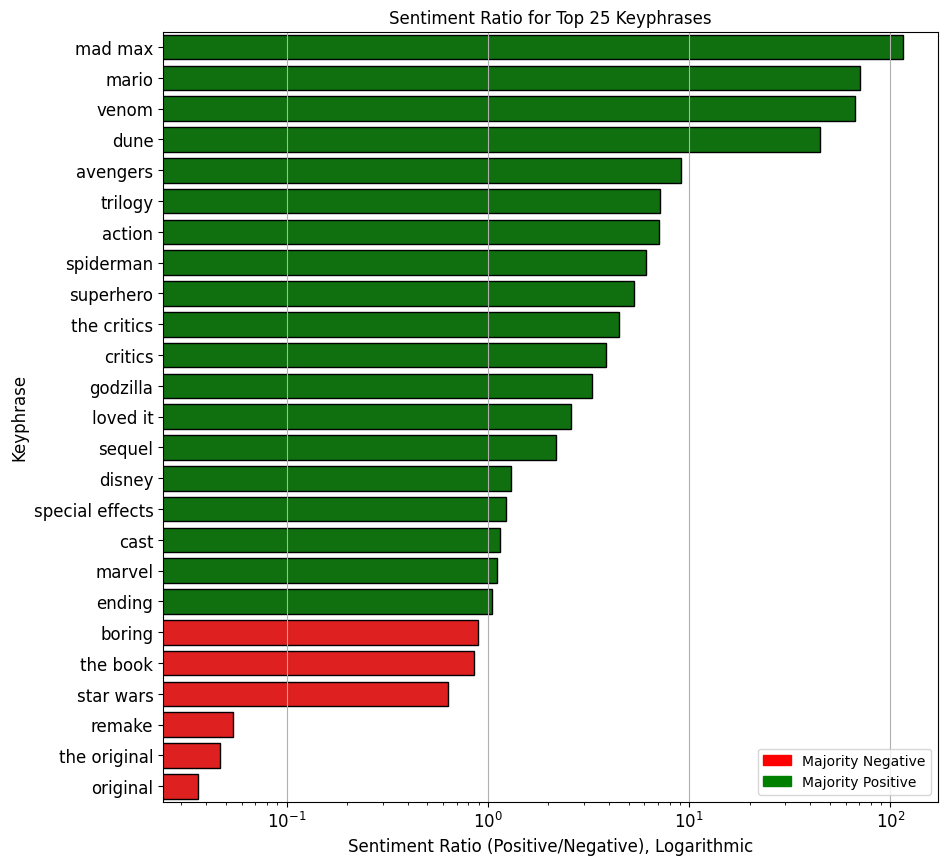

In [155]:
# Plot the sentiment ratio. Make it log scale
# Shade bars based on sentiment ratio

plt.figure(figsize=(10, 10))
colors = ['red' if ratio < 1.0 else 'green' for ratio in top100.head(25).sort_values('sentiment_ratio', ascending=False)['sentiment_ratio']]
sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=top100.head(25).sort_values('sentiment_ratio', ascending=False),
    edgecolor='black',
    palette=colors)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])


plt.show()

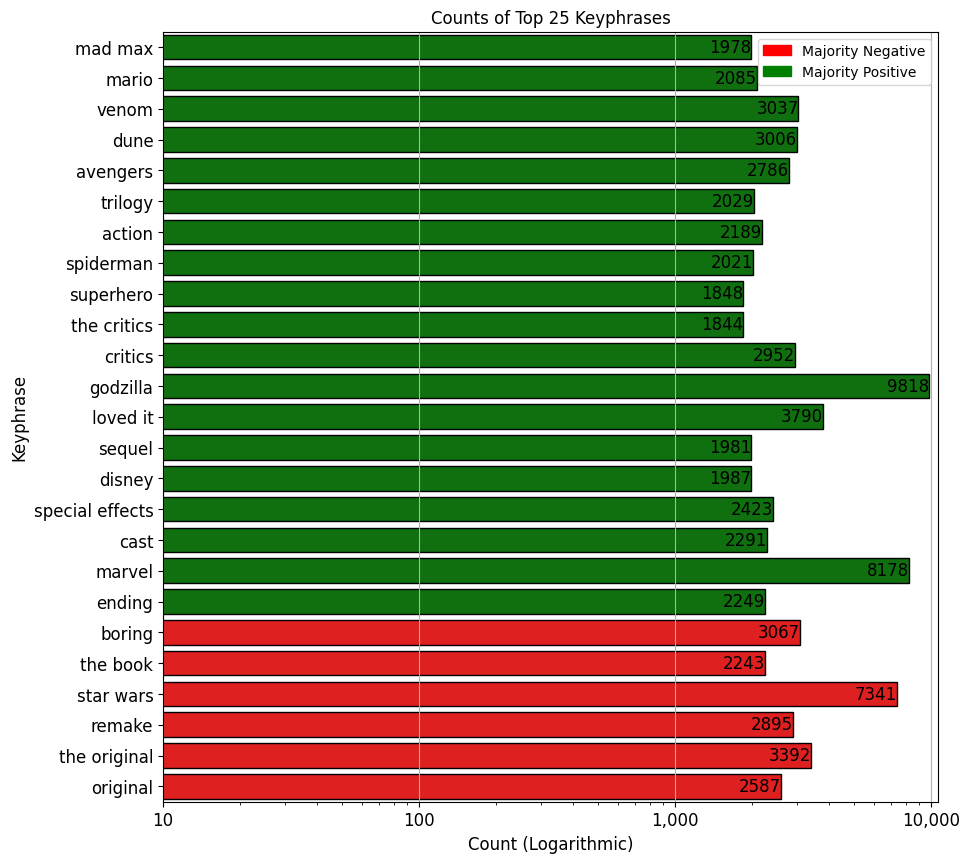

In [213]:
# Plot counts of 25 most common keyphrases.
# Vertical bar plot
plt.figure(figsize=(10, 10))
subset = top100.sort_values('count', ascending=False).head(25)
subset = subset.sort_values('sentiment_ratio', ascending=False)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors,
    log = False)

plt.grid(axis='x')
# Scale x-axis logarithmically
plt.xscale('log')
plt.title('Counts of Top 25 Keyphrases')
plt.xlabel('Count (Logarithmic)', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(ticks=[10e0, 10e1, 10e2, 10e3], labels=['10', '100', '1,000', '10,000'], fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()


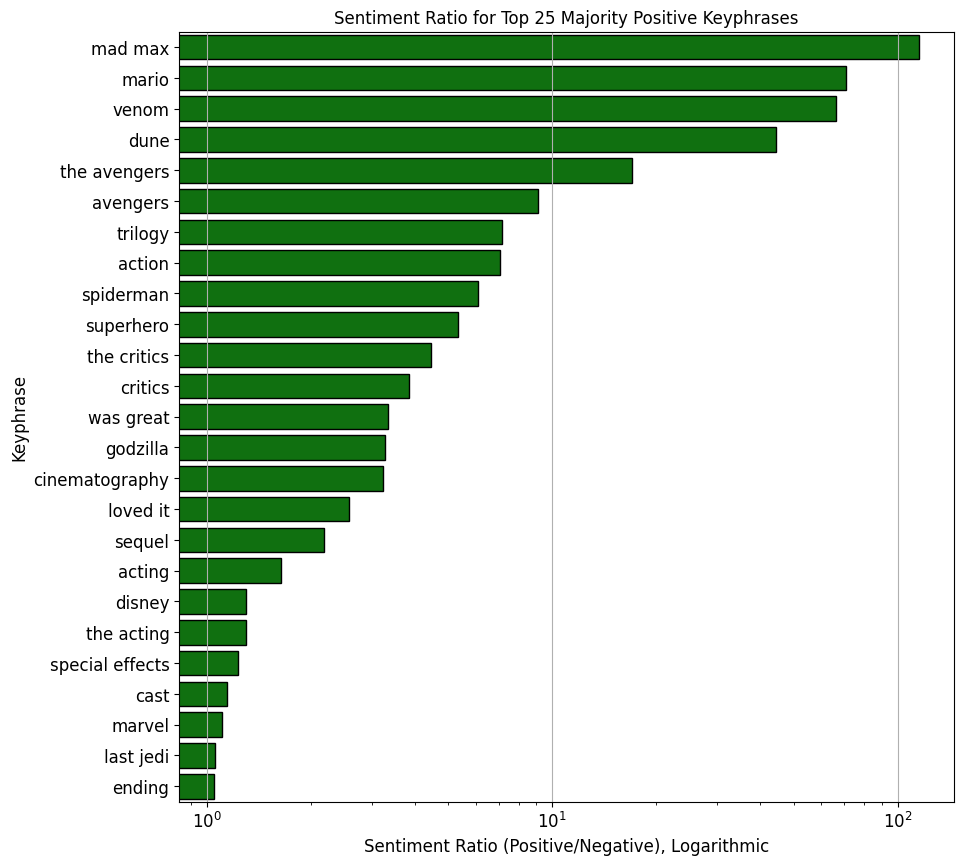

In [158]:
# Plot the sentiment ratio for the 25 most common positive keyphrases
plt.figure(figsize=(10, 10))
subset = top100[top100['sentiment_ratio'] > 1.0].head(25)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset.sort_values('sentiment_ratio', ascending=False)['sentiment_ratio']]
sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=subset.sort_values('sentiment_ratio', ascending=False),
    edgecolor='black',
    palette=colors)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Majority Positive Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

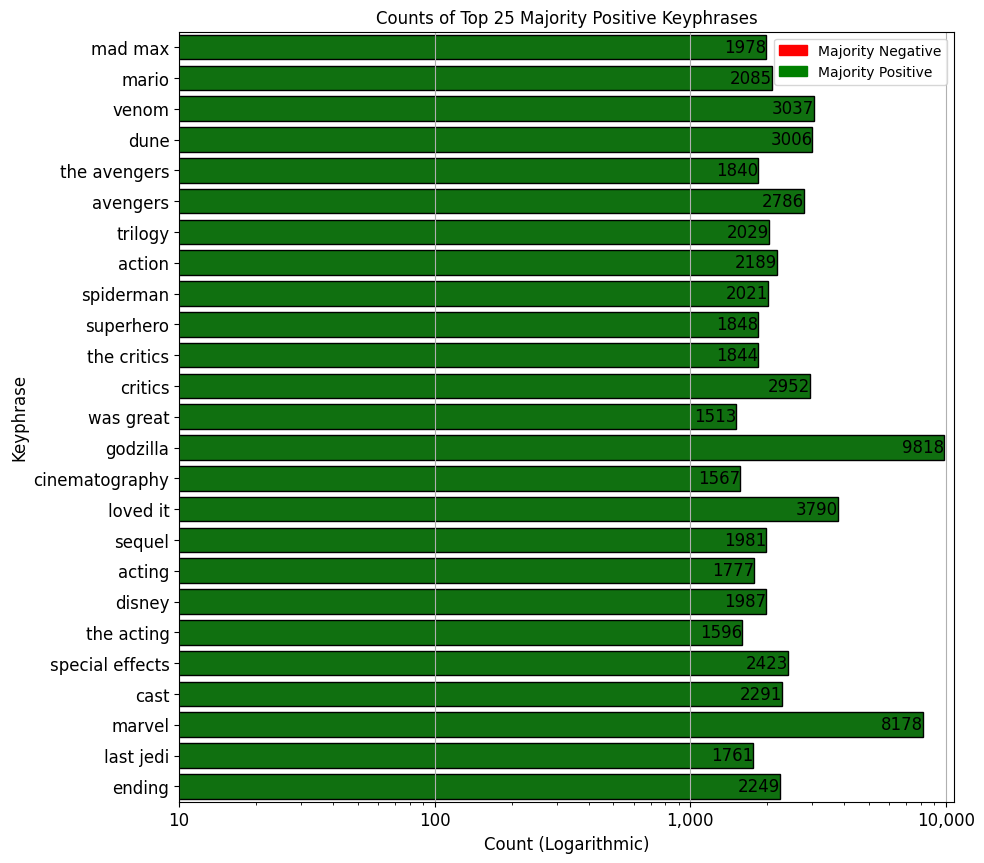

In [214]:
# Plot counts of 25 most common positive keyphrases.
# Vertical bar plot
plt.figure(figsize=(10, 10))
subset = top100[top100['sentiment_ratio'] > 1.0].sort_values('count', ascending=False).head(25)
subset = subset.sort_values('sentiment_ratio', ascending=False)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors,
    log = False)

plt.grid(axis='x')
# Scale x-axis logarithmically
plt.xscale('log')
plt.title('Counts of Top 25 Majority Positive Keyphrases')
plt.xlabel('Count (Logarithmic)', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(ticks=[10e0, 10e1, 10e2, 10e3], labels=['10', '100', '1,000', '10,000'], fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()


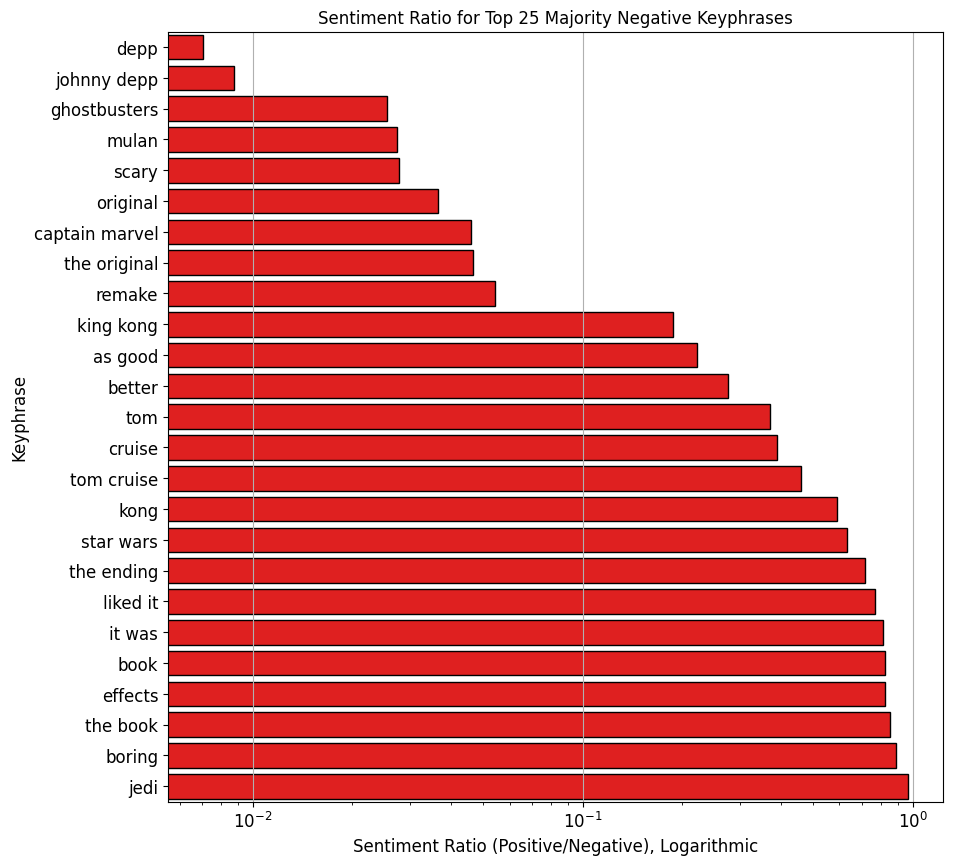

In [161]:
# Plot the sentiment ratio for the 25 most common negative keyphrases
plt.figure(figsize=(10, 10))
subset = top100[top100['sentiment_ratio'] < 1.0].head(25)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset.sort_values('sentiment_ratio', ascending=True)['sentiment_ratio']]
sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=subset.sort_values('sentiment_ratio', ascending=True),
    edgecolor='black',
    palette=colors)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Majority Negative Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

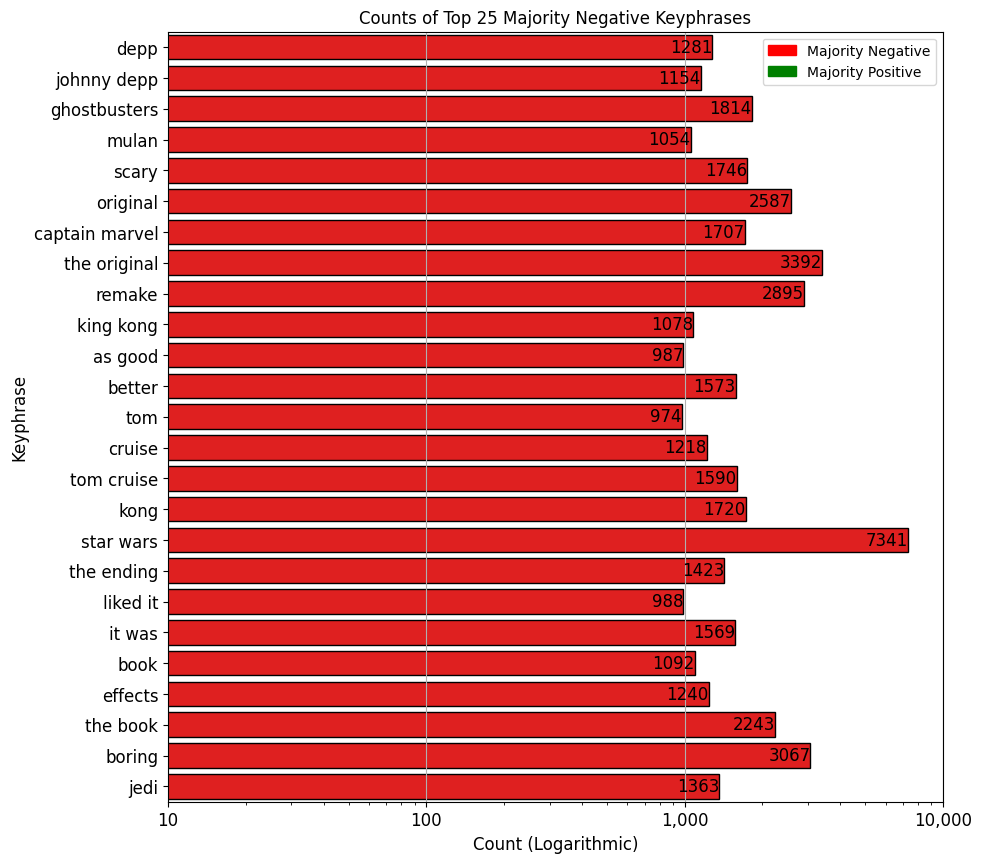

In [215]:
# Plot counts of 25 most common positive keyphrases.
# Vertical bar plot
plt.figure(figsize=(10, 10))
subset = top100[top100['sentiment_ratio'] < 1.0].sort_values('count', ascending=False).head(25)
subset = subset.sort_values('sentiment_ratio', ascending=True)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors,
    log = False)

plt.grid(axis='x')
# Scale x-axis logarithmically
plt.xscale('log')
plt.title('Counts of Top 25 Majority Negative Keyphrases')
plt.xlabel('Count (Logarithmic)', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(ticks=[10e0, 10e1, 10e2, 10e3], labels=['10', '100', '1,000', '10,000'], fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()


In [5]:
# Create critic-only table
db.execute("CREATE TABLE IF NOT EXISTS critic_keyphrases (id INTEGER, keyphrase VARCHAR, confidence FLOAT)")
# Grab the critic keyphrases from the keyphrases table
db.execute("INSERT INTO critic_keyphrases SELECT * FROM keyphrases WHERE ID IN (SELECT ID FROM embeddings384 WHERE Viewer = 'Critic')")
db.commit()




NameError: name 'db' is not defined

In [10]:
# Get the keyphrases for critics
c_keyphrases = db.execute("SELECT * FROM critic_keyphrases").fetch_df()
# Filter out 'movie', 'movies', 'film', and 'films', 'movie review', 'film review'
c_keyphrases['keyphrase'] = c_keyphrases['keyphrase'].str.replace('movie|movies|film|films|movie review|film review', '', case=False)
c_keyphrases = c_keyphrases[c_keyphrases['keyphrase'].str.len() > 0]
# Get the top 100 keyphrases
c_top100 = c_keyphrases['keyphrase'].value_counts()[:100].index.tolist()
# Make dataframe
c_top100 = pd.DataFrame(c_top100, columns=['keyphrase'])
c_top100['count'] = 0
c_top100['sentiment_ratio'] = 0.0
c_top100['id'] = 0
# Get the count and sentiment ratio for each keyphrase
for i in range(len(c_top100)):
        keyphrase = c_top100['keyphrase'][i]
        ids = c_keyphrases[c_keyphrases['keyphrase'] == keyphrase]['id'].values
        c_top100['count'][i] = len(ids)
        sentiments = db.execute("SELECT Sentiment FROM embeddings384 WHERE ID IN ({})".format(', '.join([str(i) for i in ids]))).fetch_df()
        pos = sentiments[sentiments['Sentiment'] == 'Positive'].shape[0]
        neg = sentiments[sentiments['Sentiment'] == 'Negative'].shape[0]
        if neg == 0:
                c_top100['sentiment_ratio'][i] = 1.0
        else:
                c_top100['sentiment_ratio'][i] = pos / neg
        c_top100['id'][i] = ids[0]
c_top100 = c_top100.sort_values('count', ascending=False)
c_top100



/tmp/ipykernel_417040/2583341676.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  c_keyphrases['keyphrase'] = c_keyphrases['keyphrase'].str.replace('movie|movies|film|films|movie review|film review', '', case=False)
/tmp/ipykernel_417040/2583341676.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_top100['count'][i] = len(ids)


/tmp/ipykernel_417040/2583341676.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_top100['sentiment_ratio'][i] = pos / neg
/tmp/ipykernel_417040/2583341676.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_top100['id'][i] = ids[0]
/tmp/ipykernel_417040/2583341676.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_top100['sentiment_ratio'][i] = 1.0


,keyphrase,count,sentiment_ratio,id
0,godzilla,167,0.427350,206836
1,last jedi,115,1.804878,97588
2,star wars,112,0.647059,97590
3,marvel,100,3.761905,186570
4,dune,97,96.000000,110183
...,...,...,...,...
95,godzilla franchise,14,0.400000,206869
96,action,14,13.000000,206839
97,this,13,0.857143,4306
98,adam,13,0.000000,124408


In [18]:
c_top100[10:20]

,keyphrase,count,sentiment_ratio,id
10,captain marvel,59,58.000000,55407
11,mario bros,56,0.000000,165367
12,super mario,53,0.000000,165367
13,fury road,52,51.000000,18164
14,aquaman,51,0.000000,36266
15,fifty shades,51,0.000000,4295
16,mad max,48,23.000000,18124
17,marvel cinematic,46,22.000000,186563
18,spiderman,45,0.046512,186632
19,godzilla vs,44,0.023256,206901


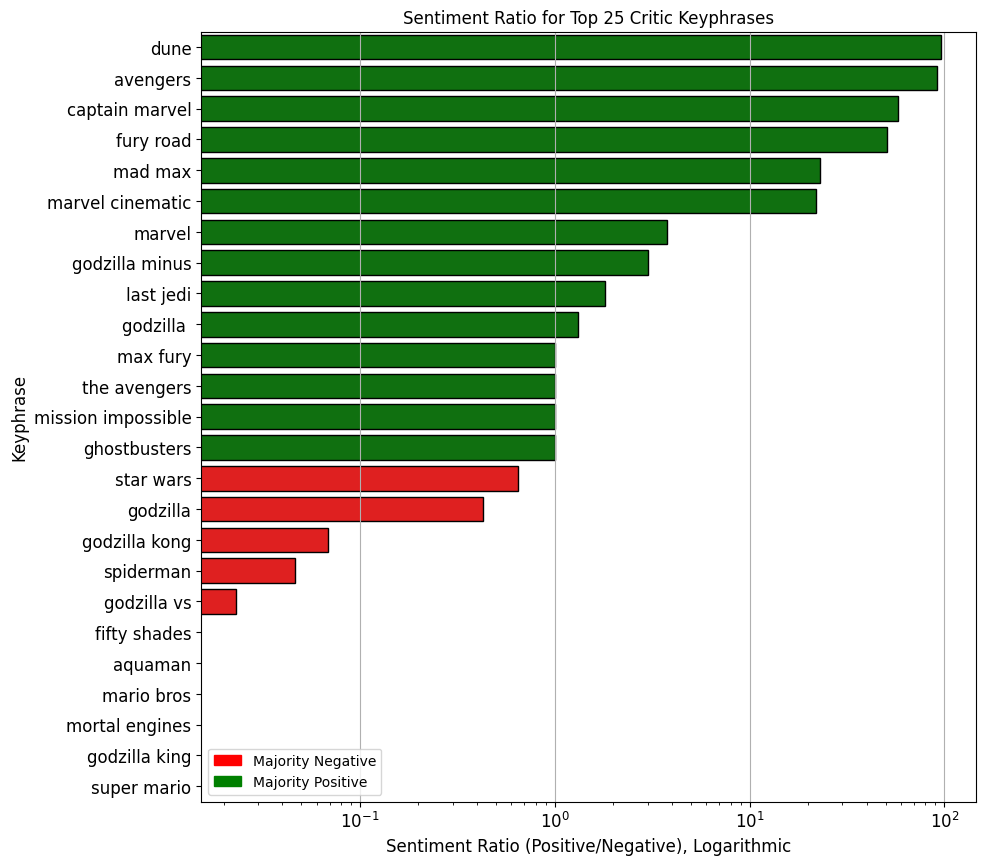

In [24]:
# Plot the sentiment ratio. Make it log scale
# Shade bars based on sentiment ratio

plt.figure(figsize=(10, 10))
subset = c_top100.head(25)
# Add small jitter to 0.0 values
colors = ['red' if ratio < 1.0 else 'green' for ratio in c_top100.head(25).sort_values('sentiment_ratio', ascending=False)['sentiment_ratio']]

sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=c_top100.head(25).sort_values('sentiment_ratio', ascending=False),
    edgecolor='black',
    palette=colors,
    log=True)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Critic Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])


plt.show()

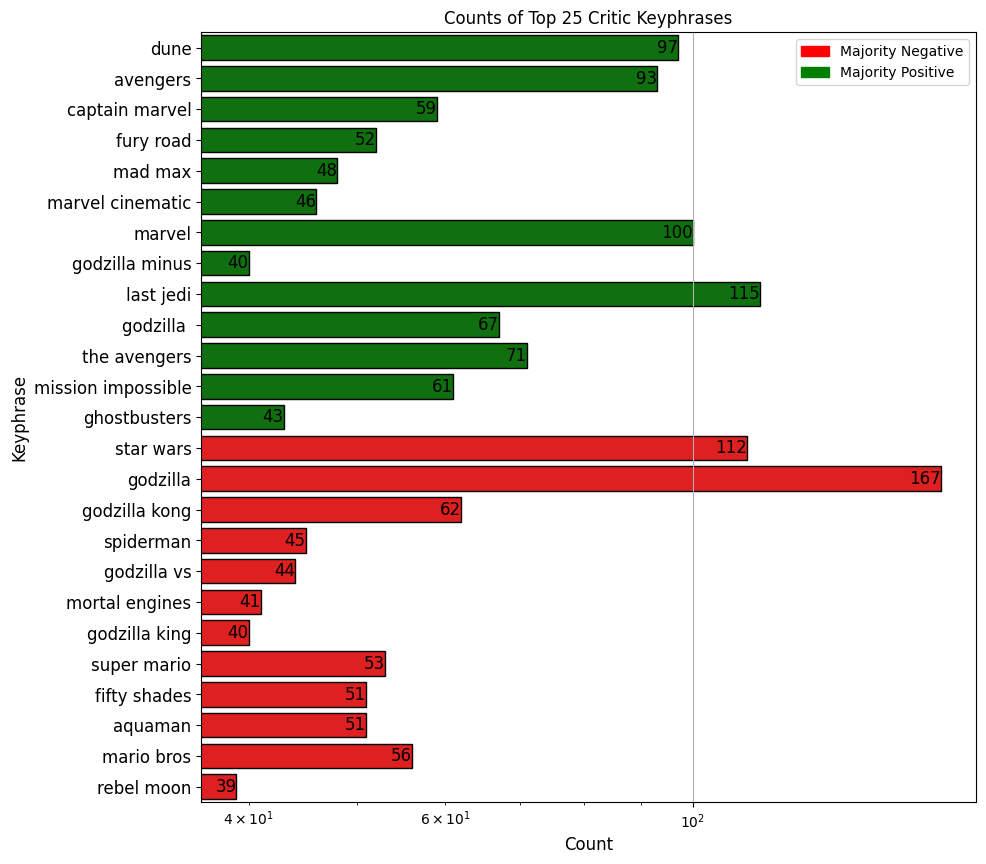

In [23]:
# Plot counts of 25 most common keyphrases.
# Vertical bar plot
plt.figure(figsize=(10, 10))
subset = c_top100.sort_values('count', ascending=False).head(25)
subset = subset.sort_values('sentiment_ratio', ascending=False)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors,)
    #log = False)

plt.grid(axis='x')
# Scale x-axis logarithmically
plt.xscale('log')
plt.title('Counts of Top 25 Critic Keyphrases')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
#plt.xticks(ticks=[10e0, 10e1, 10e2, 10e3], labels=['10', '100', '1,000', '10,000'], fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()


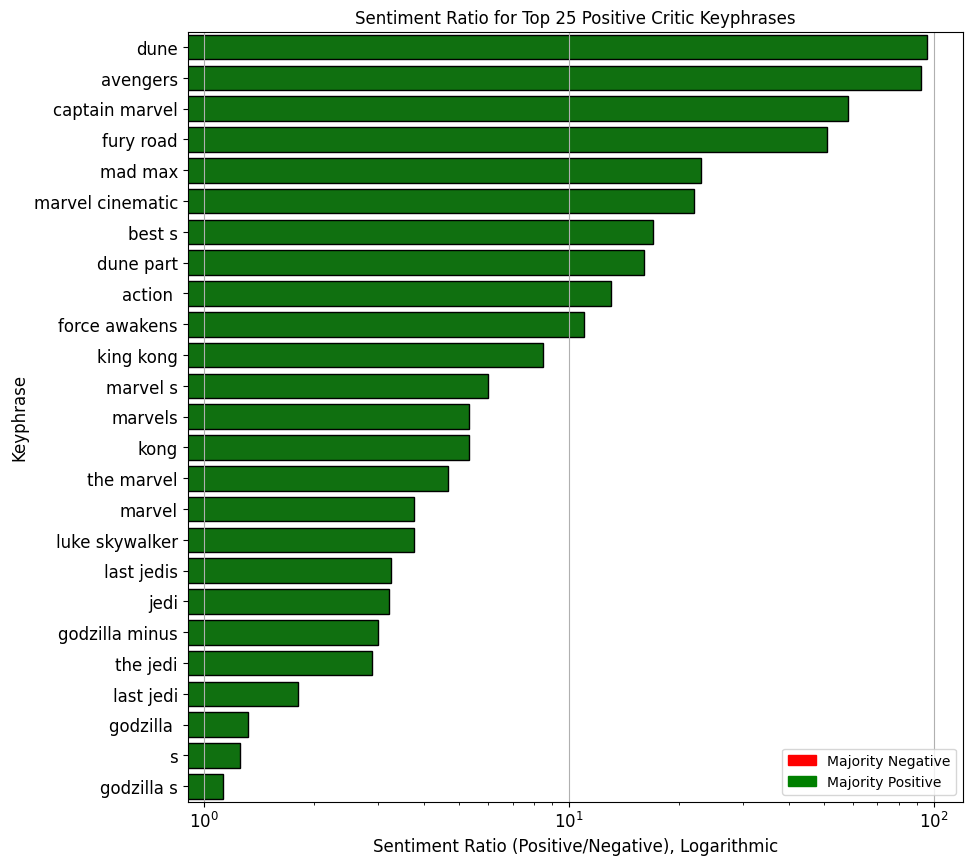

In [25]:
# Plot the sentiment ratio for the 25 most common positive critic keyphrases

plt.figure(figsize=(10, 10))
subset = c_top100.sort_values('sentiment_ratio', ascending=False).head(25)
# Add small jitter to 0.0 values
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset.sort_values('sentiment_ratio', ascending=False)['sentiment_ratio']]

sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=subset.sort_values('sentiment_ratio', ascending=False),
    edgecolor='black',
    palette=colors,
    log=True)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Positive Critic Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])


plt.show()

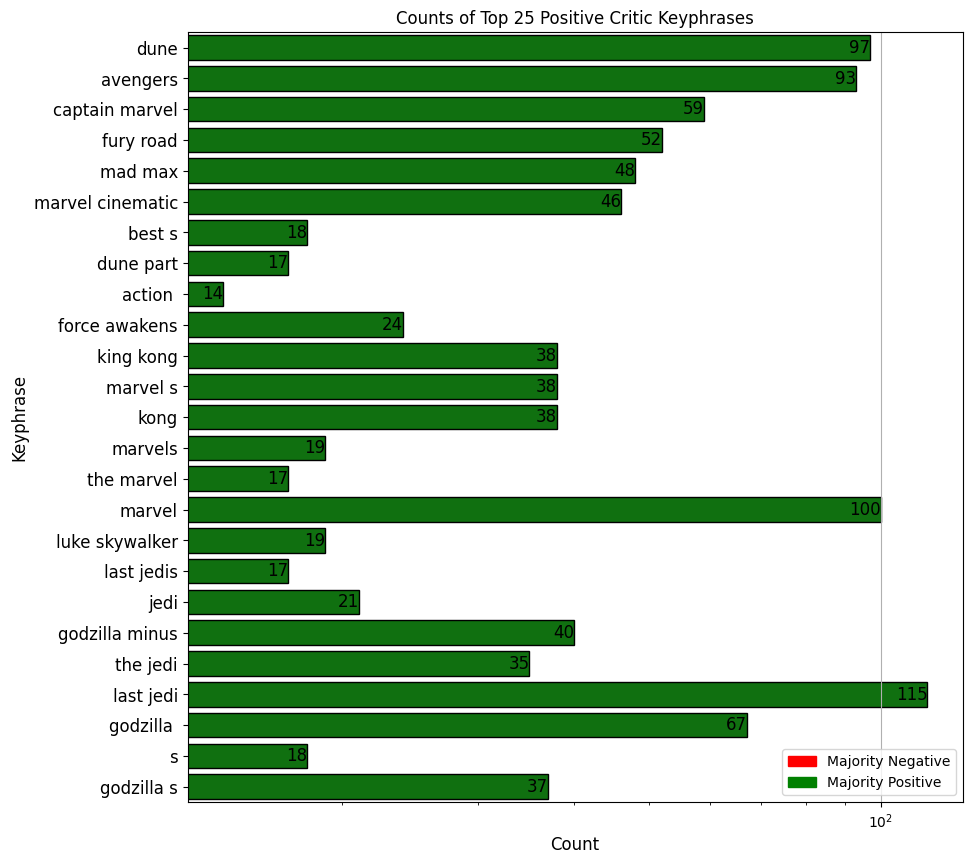

In [26]:
# Plot counts of 25 most common keyphrases.
# Vertical bar plot
plt.figure(figsize=(10, 10))
subset = c_top100.sort_values('sentiment_ratio', ascending=False).head(25)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors,)
    #log = False)

plt.grid(axis='x')
# Scale x-axis logarithmically
plt.xscale('log')
plt.title('Counts of Top 25 Positive Critic Keyphrases')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
#plt.xticks(ticks=[10e0, 10e1, 10e2, 10e3], labels=['10', '100', '1,000', '10,000'], fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()


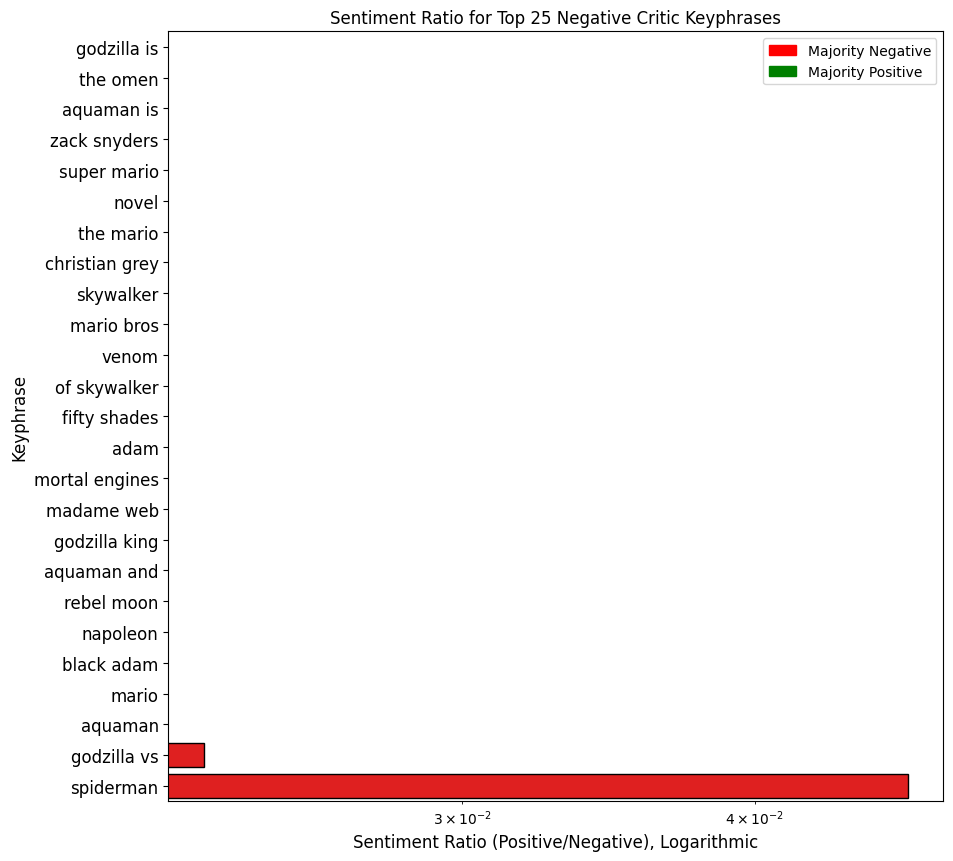

In [27]:
# Plot the sentiment ratio for the 25 most common negative critic keyphrases
subset = c_top100.sort_values('sentiment_ratio', ascending=True).head(25)
# Add small jitter to 0.0 values
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset.sort_values('sentiment_ratio', ascending=True)['sentiment_ratio']]
plt.figure(figsize=(10, 10))
sns.barplot(
    x='sentiment_ratio',
    y='keyphrase',
    data=subset.sort_values('sentiment_ratio', ascending=True),
    edgecolor='black',
    palette=colors,
    log=True)
plt.xscale('log')
plt.grid(axis='x')
plt.title('Sentiment Ratio for Top 25 Negative Critic Keyphrases')
plt.xlabel('Sentiment Ratio (Positive/Negative), Logarithmic', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Add a legend. Red is negative, green is positive
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Majority Negative')
green_patch = mpatches.Patch(color='green', label='Majority Positive')
plt.legend(handles=[red_patch, green_patch])
plt.show()

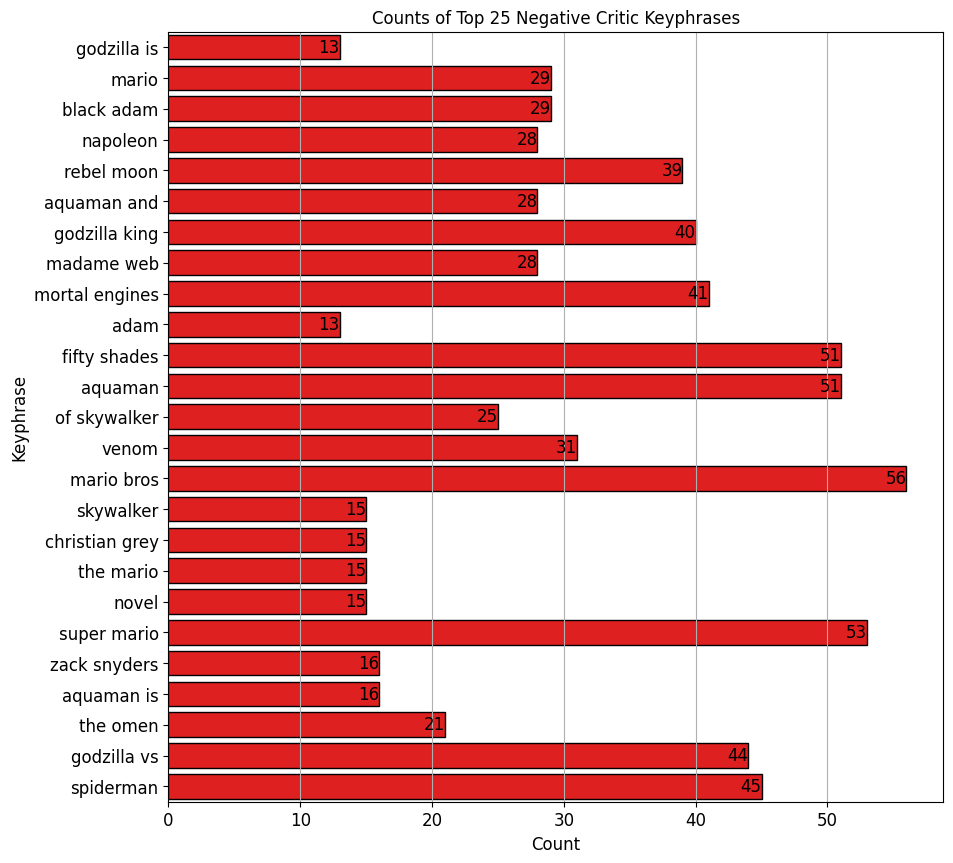

In [28]:
# Plot counts of 25 most common critic negative keyphrases.
subset = c_top100.sort_values('sentiment_ratio', ascending=True).head(25)
colors = ['red' if ratio < 1.0 else 'green' for ratio in subset['sentiment_ratio']]
plt.figure(figsize=(10, 10))
sns.barplot(
    x='count',
    y='keyphrase',
    data=subset[['keyphrase', 'count']],
    edgecolor='black',
    palette=colors)
plt.grid(axis='x')
plt.title('Counts of Top 25 Negative Critic Keyphrases')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Keyphrase', fontsize=12)
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Display count numerically on the bars
counts = subset['count'].values
for i in range(len(subset)):
    plt.text(
        x=counts[i],
        y=i,
        s=counts[i],
        va='center',
        ha='right',
        fontsize=12,
        color='black')
plt.show()

### 2.4. Frequency of Words in the Text

In [18]:
# Find the most common keywords
from collections import Counter
# List of lists of strings
keywords = [sublist.split(', ') for sublist in df['Keywords']]
# List of lists of tuples (keyword, score)
keywords = [[tuple(x.split(':')) for x in sublist] for sublist in keywords]
# Convert scores to floats
keywords = [[(x[0], float(x[1])) for x in sublist] for sublist in keywords]
# Add the Sentiment, Movie, and Viewer columns to each sublist
df["Keywords"] = keywords
df


,Viewer,Movie,Sentiment,Reviews,EmbeddingValue,ID,EmbeddingValue100,Keywords
0,Audience,war_of_the_worlds,Negative,overall good movie but it wasnt near as good a...,"[-0.09393361955881119, 0.14137916266918182, -0...",102401,"[-0.11742477864027023, 0.03308920934796333, 0....","[(good movie, 0.5314), (wasnt near, 0.3747), (..."
1,Audience,war_of_the_worlds,Negative,another classic spielberg movie,"[-0.08732374757528305, 0.12564541399478912, -0...",102402,"[-0.10003605484962463, 0.013633809052407742, 0...","[(classic spielberg, 0.8679), (spielberg movie..."
2,Audience,war_of_the_worlds,Negative,not as good as the original and im not a fan o...,"[-0.0937475636601448, 0.1473560929298401, 0.00...",102403,"[-0.12708674371242523, 0.05111914873123169, 0....","[(tom cruise, 0.5123), (cruise, 0.4093), (of t..."
3,Audience,war_of_the_worlds,Negative,that scene close to the beginning where all of...,"[-0.07822681963443756, 0.13861910998821259, 0....",102404,"[-0.09054797887802124, -0.06049513816833496, -...","[(the aliens, 0.5004), (that scene, 0.4805), (..."
4,Audience,war_of_the_worlds,Negative,i liked this a lot i think it is a genuinely k...,"[-0.07931607216596603, 0.11045075953006744, 0....",102406,"[-0.0639713704586029, -0.11278004199266434, -0...","[(scary movie, 0.5861), (scary, 0.3886), (of s..."
...,...,...,...,...,...,...,...,...
29363,Audience,mad_max_fury_road,Positive,the first 10 minutes are intense and are an ex...,"[0.007855917327105999, 0.03939059004187584, 0....",213849,"[0.4214080572128296, -0.27531519532203674, 0.0...","[(hardys character, 0.4042), (theron hardy, 0...."
29364,Audience,mad_max_fury_road,Positive,max should have simply been removed from this ...,"[-0.054594580084085464, 0.11290375888347626, -...",213850,"[0.0020585989113897085, -0.18845155835151672, ...","[(max should, 0.4518), (entire movie, 0.3374),..."
29365,Audience,mad_max_fury_road,Positive,the best film ive seen since inception,"[-0.07751371711492538, 0.11084899306297302, -0...",213851,"[-0.09917005896568298, 0.03012166917324066, 0....","[(inception, 0.714), (best film, 0.7134), (sin..."
29366,Audience,mad_max_fury_road,Positive,i was never a huge mad max fan i def enjoyed t...,"[-0.05924630165100098, 0.06459911912679672, -0...",213852,"[0.10719165951013565, -0.2997397780418396, -0....","[(mad max, 0.5489), (first trailer, 0.3931), (..."


In [21]:
# Get a flat list of only the keywords
keyword_counts = Counter([x[0] for sublist in df["Keywords"] for x in sublist])
keyword_counts.most_common(10)


[('movie', 2618),
 ('godzilla', 2592),
 ('mad max', 1293),
 ('tom cruise', 957),
 ('this movie', 872),
 ('the book', 787),
 ('cruise', 775),
 ('fury road', 674),
 ('tom', 663),
 ('the movie', 662)]

In [ ]:
keyword_counts_pos = Counter([x[0] for sublist in df["Keywords"] for x in sublist if x[2] == 'Positive'])
keyword_counts_neg = Counter([x[0] for sublist in df["Keywords"] for x in sublist if x[2] == 'Negative'])
pd.DataFrame(keyword_counts.most_common(10), columns=['Keyword', 'Count'])


In [42]:
keyword_df

,Keyword,Score,Sentiment,Viewer,ID
0,good movie,0.5314,Negative,Audience,102401
1,wasnt near,0.3747,Negative,Audience,102401
2,movie but,0.3652,Negative,Audience,102401
3,hoped,0.3552,Negative,Audience,102401
4,as expected,0.3492,Negative,Audience,102401
...,...,...,...,...,...
1267577,good film,0.4862,Negative,Audience,100869
1267578,an epic,0.4658,Negative,Audience,100869
1267579,film though,0.4521,Negative,Audience,100869
1267580,epic but,0.4370,Negative,Audience,100869


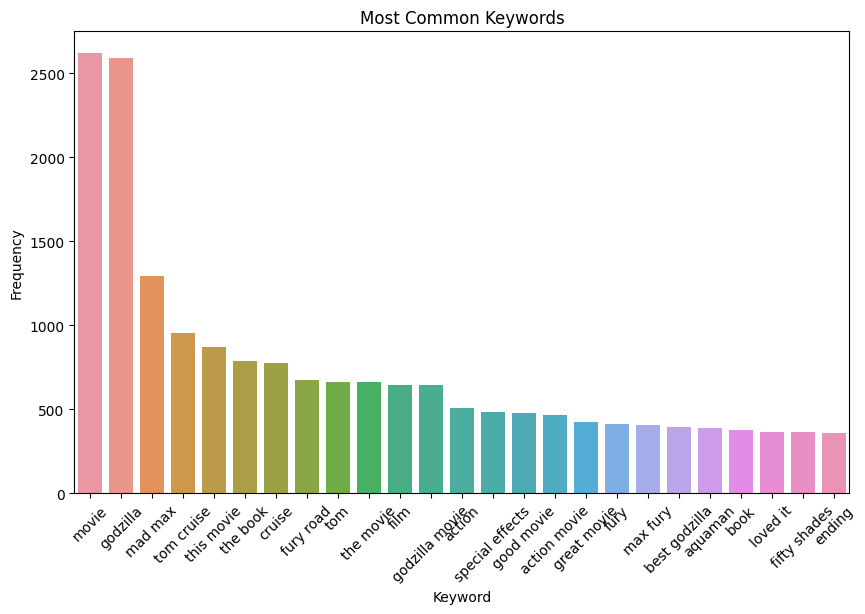

In [9]:

# Plot the 25 most common keywords in a bar plot for both positive and negative reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=[keyword[0] for keyword in keyword_counts.most_common(25)], y=[keyword[1] for keyword in keyword_counts.most_common(25)])
plt.title('Most Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

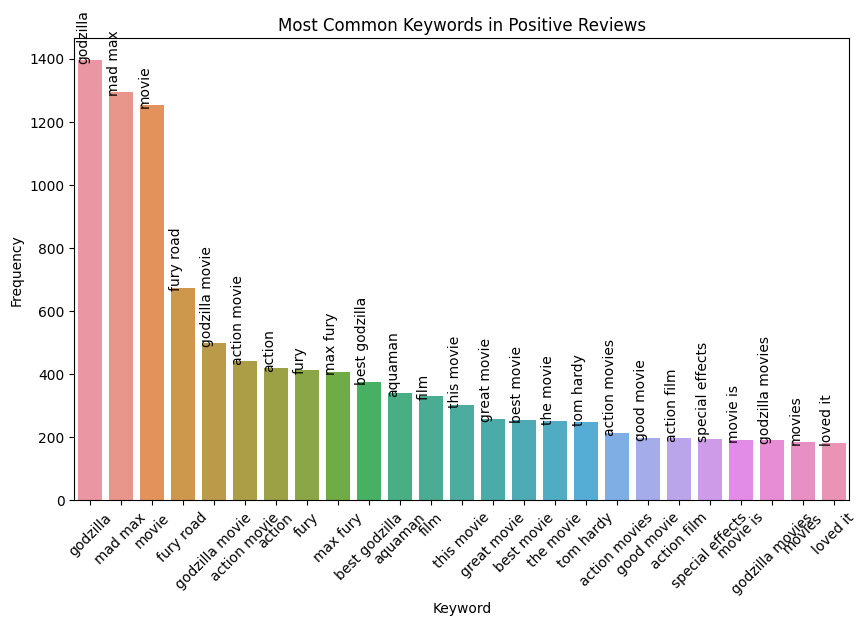

In [13]:
# 25 most common keywords for positive reviews. Label each keyword with
# movie title and viewer.   
plt.figure(figsize=(10, 6))
sns.barplot(x=[keyword[0] for keyword in keyword_counts_pos.most_common(25)], y=[keyword[1] for keyword in keyword_counts_pos.most_common(25)])
plt.title('Most Common Keywords in Positive Reviews')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for i, keyword in enumerate(keyword_counts_pos.most_common(25)):
    plt.text(i, keyword[1], f'{keyword[0]}', rotation=90, ha='right')
        
plt.show()

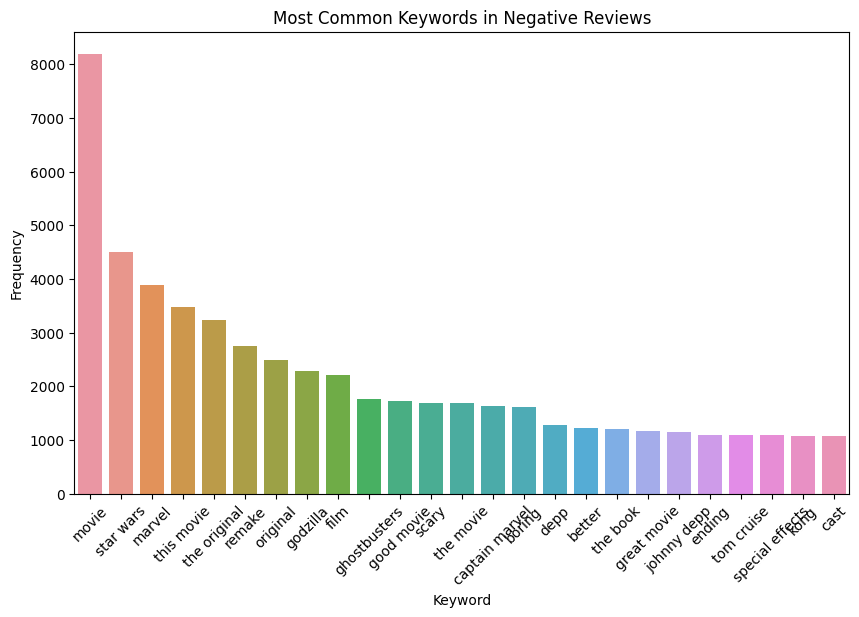

In [50]:
# 25 most common keywords for positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=[keyword[0] for keyword in keyword_counts_neg.most_common(25)], y=[keyword[1] for keyword in keyword_counts_neg.most_common(25)])
plt.title('Most Common Keywords in Negative Reviews')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Print each movie and the number of positive and negative reviews
movie_counts = df['Movie'].value_counts()

for movie in movie_counts.index:
    pos = df[(df['Movie'] == movie) & (df['Sentiment'] == 'Positive')].shape[0]
    neg = df[(df['Movie'] == movie) & (df['Sentiment'] == 'Negative')].shape[0]
    print(f'{movie}: {pos} positive reviews, {neg} negative reviews')

war_of_the_worlds: 92 positive reviews, 7777 negative reviews
mad_max_fury_road: 6771 positive reviews, 0 negative reviews
fifty_shades_of_grey: 0 positive reviews, 4393 negative reviews
godzilla: 0 positive reviews, 3799 negative reviews
aquaman_and_the_lost_kingdom: 2456 positive reviews, 93 negative reviews
godzilla_minus_one: 2117 positive reviews, 0 negative reviews
argylle: 1870 positive reviews, 0 negative reviews


### 2.5. Frequency of Sentiments in the Text

In [ ]:
# Keywords vs Sentiment
sentiment_keywords = {}
for sentiment in df['Sentiment'].unique():
    sentiment_keywords[sentiment] = [keyword for sublist in df[df['Sentiment'] == sentiment]['Keywords'] for keyword in sublist]
sentiment_keyword_counts = {sentiment: Counter(sentiment_keywords[sentiment]) for sentiment in sentiment_keywords}

# Plot the most common keywords by sentiment
plt.figure(figsize=(10, 6))
for sentiment in sentiment_keyword_counts:
    sns.barplot(x=[keyword[0] for keyword in sentiment_keyword_counts[sentiment].most_common(10)], y=[keyword[1] for keyword in sentiment_keyword_counts[sentiment].most_common(10)], label=sentiment)
plt.title('Most Common Keywords by Sentiment')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()


### 2.8. Word Clouds by Sentiment

In [ ]:
# Word Cloud by Sentiment
from wordcloud import WordCloud
plt.figure(figsize=(10, 6))
for sentiment in sentiment_keywords:
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(sentiment_keywords[sentiment]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

In [4]:
keywords = pd.read_pickle('keywords.pkl')

In [5]:
# Save the data back to the database
try:
    db.execute("ALTER TABLE embeddings384 DROP COLUMN Keywords")
except:
    pass
df = pd.read_sql('SELECT * FROM embeddings384', db)
df["Keywords"] = keywords
df.to_sql('embeddings384', db, if_exists='replace', index=False)

/tmp/ipykernel_2130/1359533360.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM embeddings384', db)
/tmp/ipykernel_2130/1359533360.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df.to_sql('embeddings384', db, if_exists='replace', index=False)


TransactionException: TransactionContext Error: cannot rollback - no transaction is active

: 

In [ ]:
db.commit()

In [ ]:
# Use Phi-3 with the following prompt(s): 
# If the movie review is positive: "What makes this movie good?"
# If the movie review is negative: "What makes this movie bad?"

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

# Take each review and query the model
phi3 = []
for i in tqdm(range(len(df))):
    if df['Sentiment'][i] == 'Positive':
        prompt = "What makes this movie good?"
    else:
        prompt = "What makes this movie bad?"
    inputs = tokenizer(prompt + df['Reviews'][i], return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs, max_length=64, num_return_sequences=1)
    phi3.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
df['Phi-3'] = phi3
df

In [ ]:
# Save the data back to the database
db.execute("ALTER TABLE embeddings384 ADD COLUMN Phi3 VARCHAR")
db.execute("SET Phi3 = ?", [df['Phi-3']])
db.commit()

## 3. Project reviews into 2D using PCA and t-SNE to visualize potential clustering.

### PCA

In [47]:
df = db.execute("SELECT Sentiment, EmbeddingValue FROM embeddings384 WHERE Viewer = 'Audience'").fetchdf()
df100 = db.execute("SELECT Sentiment, EmbeddingValue100 FROM embeddings384 WHERE Viewer = 'Audience'").fetchdf()

In [48]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(
    df['EmbeddingValue'].tolist(),
    df['Sentiment'].tolist())
print(len(reduced_data))
print(reduced_data.shape)
# convert to dataframe
reduced_data = pd.DataFrame(
    data = {
        'x': reduced_data[:,0],
        'y': reduced_data[:,1],
        'sentiment': df['Sentiment']
    }
)
reduced_data

250284
(250284, 2)


,x,y,sentiment
0,-0.113077,-0.064121,Negative
1,-0.100518,-0.041953,Negative
2,-0.117772,-0.079983,Negative
3,-0.093179,0.051144,Negative
4,-0.069703,0.117714,Negative
...,...,...,...
250279,-0.085422,0.037035,Negative
250280,-0.135582,-0.115655,Negative
250281,-0.123243,-0.056637,Negative
250282,-0.095146,-0.025318,Negative


/home/ryangorman/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (250284) than needed (2), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/ryangorman/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (250284) than needed (2), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/ryangorman/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (250284) than needed (2), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


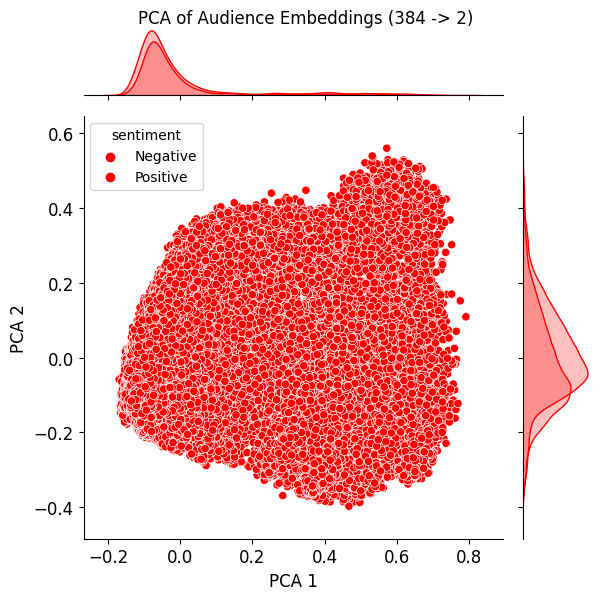

In [53]:
p = sns.jointplot(
    data=reduced_data, x="x", y="y", hue='sentiment', palette=['green', 'red'], alpha=0.5
)
p.figure.suptitle('PCA of Audience Embeddings (384 -> 2)')
# FLip legend

p.ax_joint.collections[0].set_alpha(1)
p.figure.tight_layout()
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
p.figure.subplots_adjust(top=0.95) # Reduce plot to make room 
# Adjust x and y labels
p.set_axis_labels('PCA 1', 'PCA 2', fontsize=12)
plt.show()

In [63]:
pca = PCA(n_components=2)
reduced_data100 = pca.fit_transform(
    df100['EmbeddingValue100'].tolist(),
    df100['Sentiment'].tolist())
print(len(reduced_data100))
print(reduced_data100.shape)
# convert to dataframe
reduced_data100 = pd.DataFrame(
    data = {
        'x': reduced_data100[:,0],
        'y': reduced_data100[:,1],
        'sentiment': df100['Sentiment']
    }
)
reduced_data100

250284
(250284, 2)


,x,y,sentiment
0,-0.113009,-0.064071,Negative
1,-0.100471,-0.041901,Negative
2,-0.117725,-0.079970,Negative
3,-0.093131,0.051195,Negative
4,-0.069703,0.117721,Negative
...,...,...,...
250279,-0.085398,0.037035,Negative
250280,-0.135613,-0.115732,Negative
250281,-0.123296,-0.056695,Negative
250282,-0.095123,-0.025290,Negative


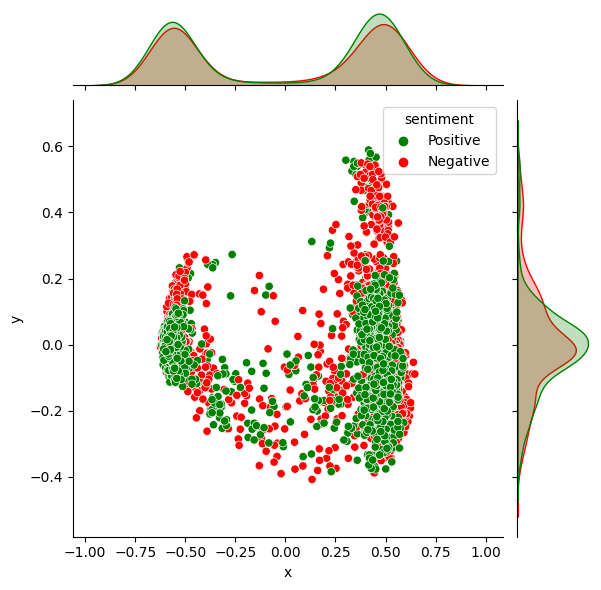

In [42]:
sns.jointplot(
    data=reduced_data100, x="x", y="y", hue="sentiment", legend=True, palette=['green', 'red'])
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 250284 samples in 0.006s...
[t-SNE] Computed neighbors for 250284 samples in 38.282s...
[t-SNE] Computed conditional probabilities for sample 1000 / 250284
[t-SNE] Computed conditional probabilities for sample 2000 / 250284
[t-SNE] Computed conditional probabilities for sample 3000 / 250284
[t-SNE] Computed conditional probabilities for sample 4000 / 250284
[t-SNE] Computed conditional probabilities for sample 5000 / 250284
[t-SNE] Computed conditional probabilities for sample 6000 / 250284
[t-SNE] Computed conditional probabilities for sample 7000 / 250284
[t-SNE] Computed conditional probabilities for sample 8000 / 250284
[t-SNE] Computed conditional probabilities for sample 9000 / 250284
[t-SNE] Computed conditional probabilities for sample 10000 / 250284
[t-SNE] Computed conditional probabilities for sample 11000 / 250284
[t-SNE] Computed conditional probabilities for sample 12000 / 250284
[t-SNE] Computed conditional probab

ValueError: Could not interpret value `t-SNE 1` for parameter `x`

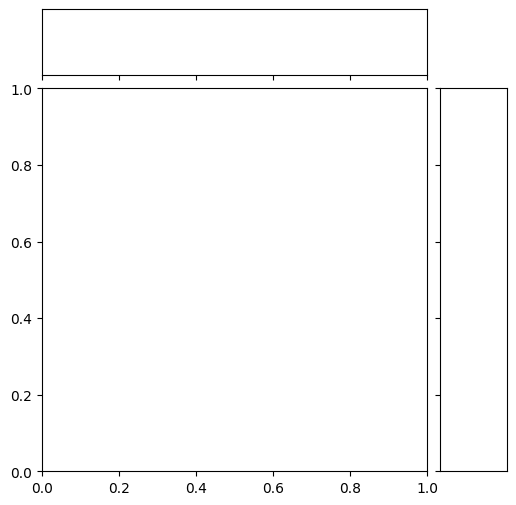

In [46]:
tsne = TSNE(n_components=2, verbose=1)
reduced_data = tsne.fit_transform(
    np.array(df100['EmbeddingValue100'].tolist()),
    df100['Sentiment'].tolist())
print(len(reduced_data))
print(reduced_data.shape)
# convert to dataframe
reduced_data = pd.DataFrame(
    data = {
        'x': reduced_data[:,0],
        'y': reduced_data[:,1],
        'sentiment': df100['Sentiment']
    }
)
p = sns.jointplot(
    data=reduced_data, x="t-SNE 1", y="t-SNE 2", hue="sentiment"
)
p.figure.suptitle('t-SNE of Audience Embeddings (100 -> 2)')
p.ax_joint.collections[0].set_alpha(1)
p.figure.tight_layout()
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
p.figure.subplots_adjust(top=0.95) # Reduce plot to make room 
# Adjust x and y labels
p.set_axis_labels('t-SNE 1', 't-SNE 2', fontsize=12)
plt.show()

In [39]:
df = db.execute("SELECT Sentiment, EmbeddingValue FROM embeddings384 WHERE Viewer = 'Audience'").fetchdf()
df100 = db.execute("SELECT Sentiment, EmbeddingValue100 FROM embeddings384 WHERE Viewer = 'Audience'").fetchdf()

250284
(250284, 2)


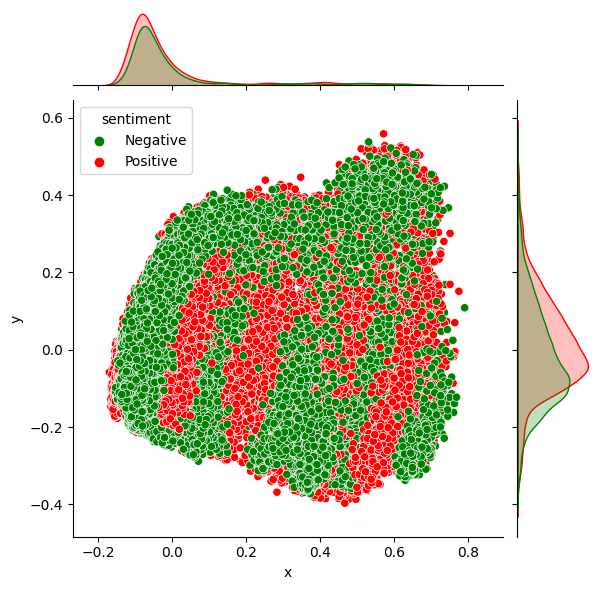

In [40]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(
    df['EmbeddingValue100'].tolist(),
    df['Sentiment'].tolist())
print(len(reduced_data))
print(reduced_data.shape)
# convert to dataframe
reduced_data = pd.DataFrame(
    data = {
        'x': reduced_data[:,0],
        'y': reduced_data[:,1],
        'sentiment': df['Sentiment']
    }
)
sns.jointplot(
    data=reduced_data, x="x", y="y", hue="sentiment", legend=True, palette=['green', 'red'])
plt.show()

3619
(3619, 2)


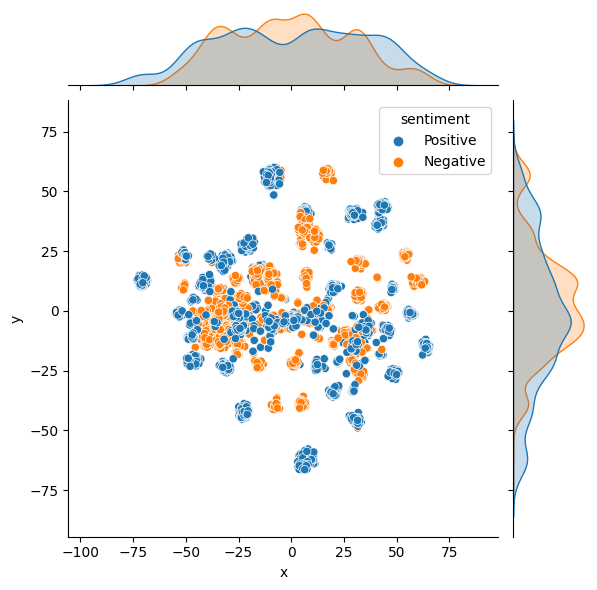

In [72]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(
    np.array(df100['EmbeddingValue100'].tolist()),
    df100['Sentiment'].tolist())
print(len(reduced_data))
print(reduced_data.shape)
# convert to dataframe
reduced_data = pd.DataFrame(
    data = {
        'x': reduced_data[:,0],
        'y': reduced_data[:,1],
        'sentiment': df100['Sentiment']
    }
)
sns.jointplot(
    data=reduced_data, x="x", y="y", hue="sentiment")
plt.show()

In [23]:
# Load critic embeddings
df = db.execute("SELECT Sentiment, EmbeddingValue FROM embeddings384 WHERE Viewer = 'Critic'").fetchdf()
df100 = db.execute("SELECT Sentiment, EmbeddingValue100 FROM embeddings384 WHERE Viewer = 'Critic'").fetchdf()


3619
(3619, 2)


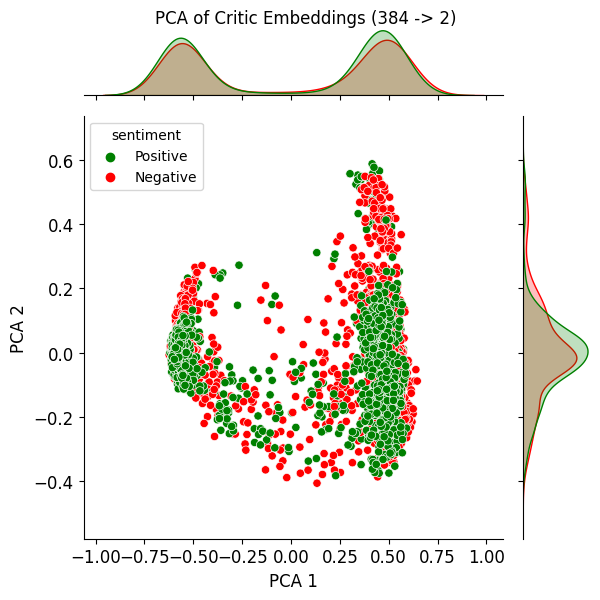

In [35]:
from matplotlib import legend


pca = PCA(n_components=2)
reduced_data100 = pca.fit_transform(
    df100['EmbeddingValue100'].tolist(),
    df100['Sentiment'].tolist())
print(len(reduced_data100))
print(reduced_data100.shape)
# convert to dataframe
reduced_data100 = pd.DataFrame(
    data = {
        'x': reduced_data100[:,0],
        'y': reduced_data100[:,1],
        'sentiment': df100['Sentiment']
    }
)
# Negative is Blue, Positive is Orange
p = sns.jointplot(
    data=reduced_data100, x="x", y="y", hue="sentiment", legend=True, palette=['green', 'red']
)


# Rename the legend
p.figure.suptitle('PCA of Critic Embeddings (384 -> 2)')
p.ax_joint.collections[0].set_alpha(1)
p.figure.tight_layout()
# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
p.figure.subplots_adjust(top=0.95) # Reduce plot to make room 
# Adjust x and y labels
p.set_axis_labels('PCA 1', 'PCA 2', fontsize=12)
plt.show()

